In [45]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
from astropy.cosmology import Planck15 as cosmo
import emcee
from scipy import optimize as op
import os
os.environ["OMP_NUM_THREADS"] = "4"
from multiprocessing import Pool
import corner
import scipy
import time
from datetime import datetime 
from IPython.display import display, Math

In [46]:
c=cte.c
Msun=cte.M_sun

In [47]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/T1 f2.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

v1=[]
ev1=[]

v2=[]
ev2=[]

v3=[]
ev3=[]

l1=[]
el1=[]

l2=[]
el2=[]

l3=[]
el3=[]


for j in rows:   
    
    ID.append(j[0])
    
    v1.append(float(j[3]))
    ev1.append(float(j[4]))
    v2.append(float(j[5]))
    ev2.append(float(j[6]))
    v3.append(float(j[7]))
    ev3.append(float(j[8]))
    l1.append(float(j[9]))
    el1.append(float(j[10]))
    l2.append(float(j[11]))
    el2.append(float(j[12]))
    l3.append(float(j[13]))
    el3.append(float(j[14]))


In [48]:
v_=[148,218,278]*un.GHz
l__=[500,350,250]*un.um
v=v_.to("Hz").value
l_=(c.to("um/s"))/(np.array([500,350,250])*un.um)
l=l_.to("Hz").value
vf=np.concatenate((v, l))

In [49]:
def tau(z,M_,d_,vf): 
    vf=vf*un.Hz
    d_=d_*un.kpc
    v0=353*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [50]:
def P(vf,T,z):
    vf=vf*un.Hz
    T=T*un.K
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [51]:
def modelSv(vf,z,T,M_,d_):
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    
    TAU=tau(z,M_,d_,vf)
    PL=P(vf,T,z)
    
    vf=vf*un.Hz
    T=T*un.K
    d_=d_*un.kpc
    
    O=np.pi*(d_/2)**2 * (D**-2)
    
    S_=O*(1-np.e**-TAU)*PL
    S=S_.to("mJy")
    return S.value

In [52]:
def A(z,Tc,M_,d_,vf): 


    v0=353*un.GHz
    b=2
    
    Tc=Tc*un.K
    Tvariable=(np.linspace(Tc.value,1000,10000)) *un.K
    
    integrales=[]
    
    for i in vf:
        ARG = modelSv(i,z,Tvariable,M_,d_)*un.mJy *(Tvariable)**-7
        integrales.append(scipy.integrate.trapz(ARG,x=Tvariable))
    
    return integrales

In [53]:
def modelSobs(vf,z,Tc,M_,d_): #Como SPT no entrega Tc tomamos Tc= T-10]
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    TCMB=2.725*un.K
    
    INTEGRAL=A(z,Tc,M_,d_,vf)
    TAU=tau(z,M_,d_,vf)
    
    h=cte.h
    K=cte.k_B
    vf=vf*un.Hz
    d_=d_*un.kpc
    Tc=Tc*un.K
    O=np.pi*(d_/2)**2 * (D**-2)
    model_=[]
    for j in range(len(vf)):
        M1=6 * Tc**6 * INTEGRAL[j]
    
        M2=O * np.e**-TAU * (2*h)/(c**2) * (vf[j]**3)/(np.e**(h*vf[j]/(K*TCMB))-1)
        model_.append(((M1+M2)[0]).value)
        
    model=model_*un.mJy

    return model.value

In [54]:
def ml_S(ID,frecsT): #Single
    
    popt,pconv = scipy.optimize.curve_fit(modelSv,vf,frecsT,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4])) 
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    plt.figure(figsize=(12,9))

    pm = [z_fit,T_fit,M_fit,d_fit]
    
    x = np.linspace(100,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value

    y = modelSv(x,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [55]:
def ml_PL_lim(ID,frecsT): #PL
    
    popt,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,35,10.,4.],bounds=([1,20,8,2],[10,50,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]
    
    x = np.linspace(100,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])
    
    

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [56]:
def ml_PL_nolim(ID,frecsT): #PL
    
    popt,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,47,10.,4.],bounds=([1,10,8,2],[10,100,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    popt
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]
    
    x = np.linspace(100,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])
    
    

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [57]:
def lnlike(theta,x,y,yerr,model):
    z,T,M_,d_ = theta
    y=np.array(y)
    yerr=np.array(yerr)
    Sv = modelSv(x,z,T,M_,d_)
    Sobs = modelSobs(x,z,T,M_,d_)
    x = x*un.Hz
    if model=="S": 
        inv_sigma2 = 1.0 / (yerr**2 + (Sv)**2 * np.exp(2*-1))
        lnlike= -0.5 * np.sum((y-(Sv))**2*inv_sigma2 - np.log(inv_sigma2))
    else: 
        inv_sigma2 = 1.0 / (yerr**2 + (Sobs)**2 * np.exp(2*-1))
        lnlike= -0.5 * np.sum((y-(Sobs))**2*inv_sigma2 - np.log(inv_sigma2))
        
    return lnlike
        

In [58]:
def lnprior(theta,model):
    z,T,M,d = theta
    if T>0 and z>0 and M>0 and d>0:
        pM= -1 * (M - 9.4)**2 / (2 * 0.5**2) #prior M (sacado de Su)
        pZ= -1 * (z - 3)**2 / (2 * 2**2) #prior Z 
        pd= -1 * (d - 4)**2 / (2 * 2**2) #prior T
        if model=="S":
            pT= -1 * (T - 55)**2 / (2 * 10**2) #prior T
        if model=="PL nolim":
            pT= -1 * (T - 55)**2 / (2 * 10**2) #prior Tc (como Tc=T-10, automaticamente restamos 10)
        if model=="PL lim":
            pT= -1 * ((T-10) - 35)**2 / (2 * 5**2) #prior Tc
        return pM+pZ+pd+pT
    return -np.inf

In [59]:
def lnprob(theta, x, y, yerr,model):
    lp = lnprior(theta,model)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr,model)

In [69]:
def mcmc_S(ID,frecsT,errfT,model): #recibe con unidades
    
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    theta,pconv = scipy.optimize.curve_fit(modelSv,vf,frecsT,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = theta
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSv(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 4, 600 # 3000 iteraciones
    pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    with Pool() as pool:
    
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(vf,np.array(frecsT),np.array(errfT),model),
                                threads=2)
    
        start = time.time()
        sampler.run_mcmc(pos, 50) #16 chains
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} minutes".format(multi_time/60))
    
    samples = sampler.chain[:,40:, :].reshape((-1, ndim))
    
    z_mcmc=[]
    T_mcmc=[]
    M_mcmc=[]
    d_mcmc=[]
    
    for i in range(ndim): #4 es ndim
        q = np.diff(np.percentile(samples[:, i], [16, 50, 84]))
        if i==0:
            z_mcmc.append([np.percentile(samples[:, 0], [16, 50, 84])[0],q[0],q[1]])
        if i==1:
            T_mcmc.append([np.percentile(samples[:, 1], [16, 50, 84])[0],q[0],q[1]])
        if i==2:
            M_mcmc.append([np.percentile(samples[:, 2], [16, 50, 84])[0],q[0],q[1]])
        if i==3:
            d_mcmc.append([np.percentile(samples[:, 3], [16, 50, 84])[0],q[0],q[1]])
            
    print("z_mcmc:",z_mcmc) 
    print("T_mcmc:",T_mcmc)
    print("M_mcmc:",M_mcmc)
    print("d_mcmc:",d_mcmc)
    
    fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],range=[(0,8),(20,100),(7.5,13),(0,12)],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])
    
    plt.savefig("Model Single {}.png".format(ID), dpi=300, format='png')
    
    return (z_mcmc,T_mcmc,M_mcmc,d_mcmc)

In [68]:
def mcmc_PL_lim(ID,frecsT,errfT,model): #recibe con unidades

    
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    theta,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,35.,10.,4.],bounds=([1,20,8,2],[10,50,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = theta
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 4, 600 # 6000 iteraciones
    pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    with Pool() as pool:
    
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(vf,np.array(frecsT),np.array(errfT),model),
                                threads=2)
    
        start = time.time()
        sampler.run_mcmc(pos, 50) #16 chains
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} minutes".format(multi_time/60))
    samples = sampler.chain[:, 40:, :].reshape((-1, ndim))
    
    for i in range(ndim): #4 es ndim
        q = np.diff(np.percentile(samples[:, i], [16, 50, 84]))
        print(np.percentile(samples[:, i], [16, 50, 84])[0],q[0],q[1])
    
    fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],range=[(0,8),(20,100),(7.5,13),(0,12)],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])
  

ACT-S J0011-0018

In [20]:
frecs0T=[v1[0],v2[0],v3[0],l1[0],l2[0],l3[0]]
errf0T=[ev1[0],ev2[0],ev3[0],el1[0],el2[0],el3[0]]

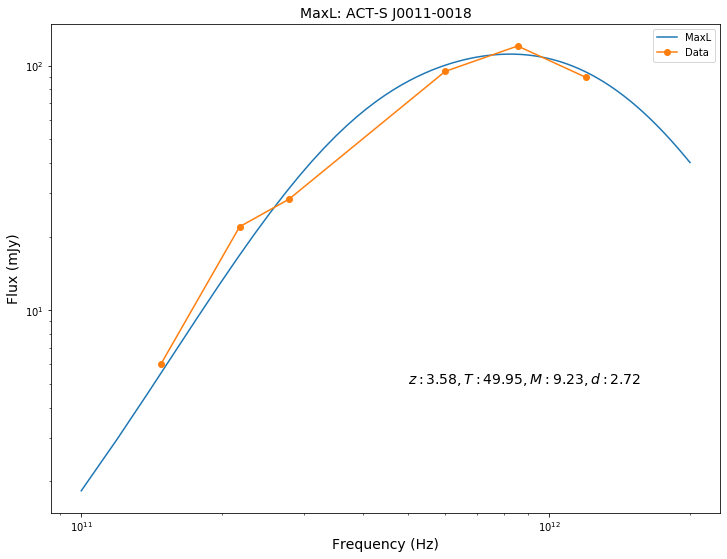

In [21]:
ml_PL_lim(ID[0],frecs0T)  #maxima semejanza para PL con limites, es decir, modelo tomando Tc entre 20 y 50K

Multiprocessing took 20.3 minutes
z_mcmc: [[1.7001432483456664, 0.6115256578139823, 0.681706736350169]]
T_mcmc: [[42.756933642232546, 1.8975256785185337, 2.327082267377442]]
M_mcmc: [[9.421885849545278, 0.2539446761035222, 0.3371411897745169]]
d_mcmc: [[2.2543567841061534, 0.662449327552034, 1.0372827786594732]]


<Figure size 864x648 with 0 Axes>

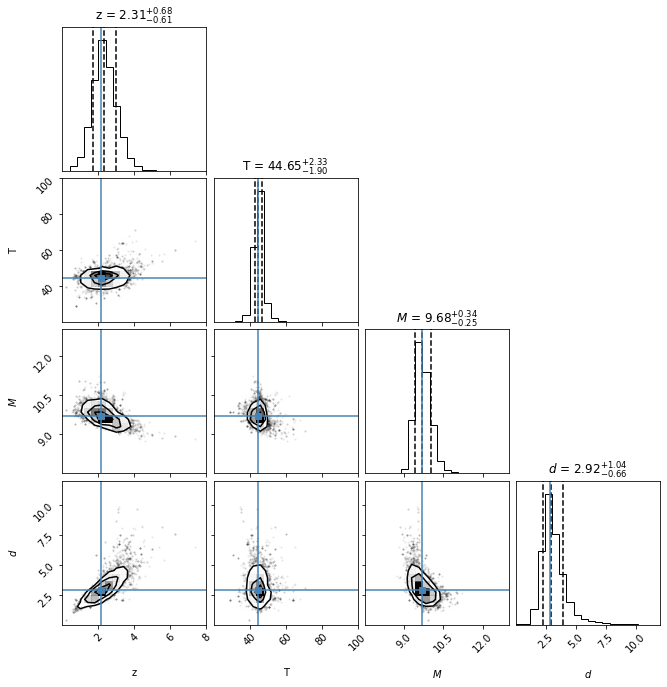

In [70]:
mcmc_S(ID[0],frecs0T,errf0T,"S") 

In [44]:
mcmc_PL_lim(ID[0],frecs0T,errf0T,"PL lim")  

Process ForkPoolWorker-55:
Process ForkPoolWorker-56:
Process ForkPoolWorker-54:
Process ForkPoolWorker-53:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run

emcee: Exception while calling your likelihood function:
  params: [ 3.52181764 51.04046609  9.17572363  2.20526118]
  args: (array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.02,  21.93,  28.43,  94.65, 120.18,  89.41]), array([2.23, 3.11, 9.74, 7.41, 6.33, 7.25]), 'PL lim')
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-15-def83b638be5>", line 5, in lnprob
    return lp + lnlike(theta, x, y, yerr,model)
  File "<ipython-input-13-c717fabbd2d9>", line 5, in lnlike
    Sv = modelSv(x,z,T,M_,d_)
  File "<ipython-input-7-92826b2579fe>", line 8, in modelSv
    TAU=tau(z,M_,d_,vf)
  File "<ipython-input-5-f0f8b200ab4c>", line 8, in tau
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
  File "/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py", line 963, in __rmul__
    return self.__mul__(other)
  File "/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py", line 947, in __mul__
    return super().__mul__(other)
  File "/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py", line 487, in __array_ufunc__
    if unit is None or result is None or result is NotImpl

KeyboardInterrupt: 

<Figure size 864x648 with 0 Axes>

De aquí en adelante se repiten las funciones en tods las galaxias de ACT.

ACT-S J0038_0022

In [24]:
frecs2T=[v1[2],v2[2],v3[2],l1[2],l2[2],l3[2]]
errf2T=[ev1[2],ev2[2],ev3[2],el1[2],el2[2],el3[2]]

Multiprocessing took 89.6 minutes
1:29:38.602616


<Figure size 864x648 with 0 Axes>

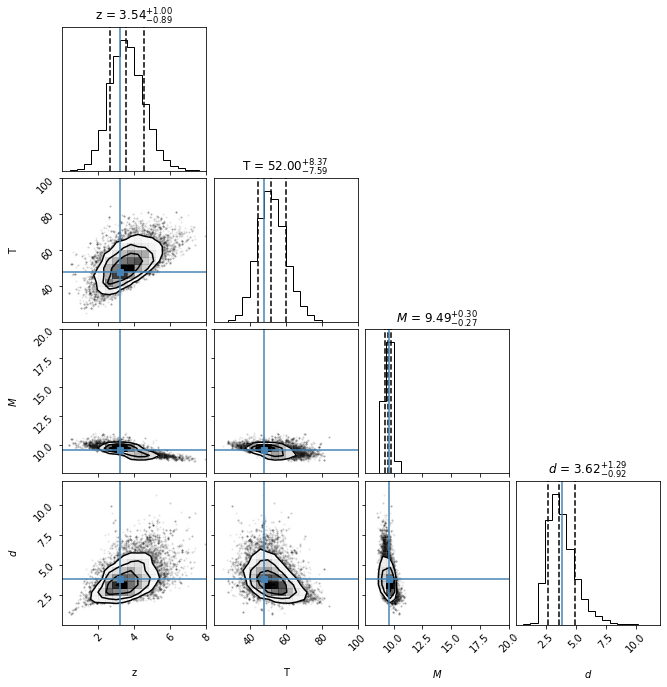

In [25]:
mcmc_S(ID[2],frecs2T,errf2T,"S")  

In [ ]:
mcmc_PL_lim(ID[2],frecs2T,errf2T,"PL lim") 

ACT-S J0039+0024

In [27]:
frecs3T=[v1[3],v2[3],v3[3],l1[3],l2[3],l3[3]]
errf3T=[ev1[3],ev2[3],ev3[3],el1[3],el2[3],el3[3]]

Multiprocessing took 88.7 minutes
1:28:45.705953


<Figure size 864x648 with 0 Axes>

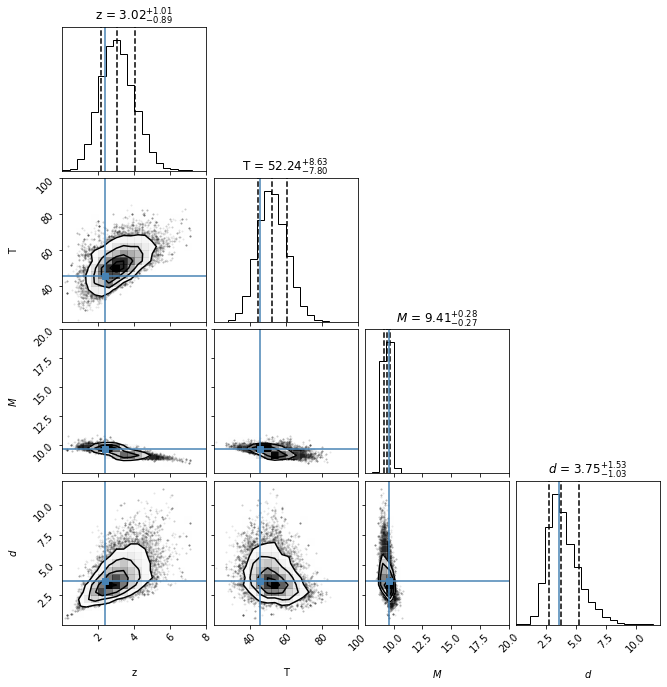

In [28]:
mcmc_S(ID[3],frecs3T,errf3T,"S") 

In [34]:
mcmc_PL_lim(ID[3],frecs3T,errf3T,"PL Lim") 

emcee: Exception while calling your likelihood function:
  params: [ 2.50462704 36.36955154  9.61944133  3.99841266]
  args: (array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-15-def83b638be5>", line 2, in lnprob
    lp = lnprior(theta,model)
  File "<ipython-input-14-169c12d6da65>", line 13, in lnprior
    return pM+pZ+pd+pT
UnboundLocalError: local variable 'pT' referenced before assignment


UnboundLocalError: local variable 'pT' referenced before assignment

<Figure size 864x648 with 0 Axes>

ACT-S J0044+0118

In [35]:
frecs4T=[v1[4],v2[4],v3[4],l1[4],l2[4],l3[4]]
errf4T=[ev1[4],ev2[4],ev3[4],el1[4],el2[4],el3[4]]

Multiprocessing took 161.0 minutes
2:41:02.279116


<Figure size 864x648 with 0 Axes>

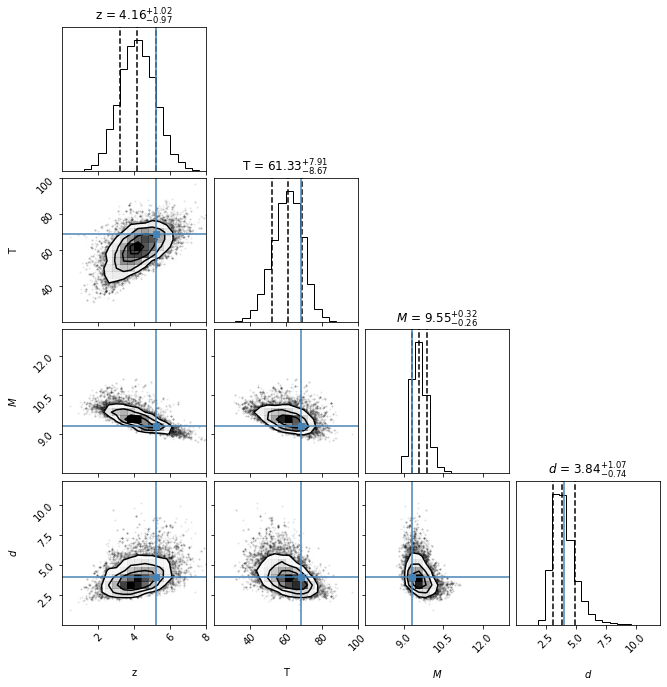

In [36]:
mcmc_S(ID[4],frecs4T,errf4T,"S") 

Multiprocessing took 131.2 minutes
2:11:15.187935


<Figure size 864x648 with 0 Axes>

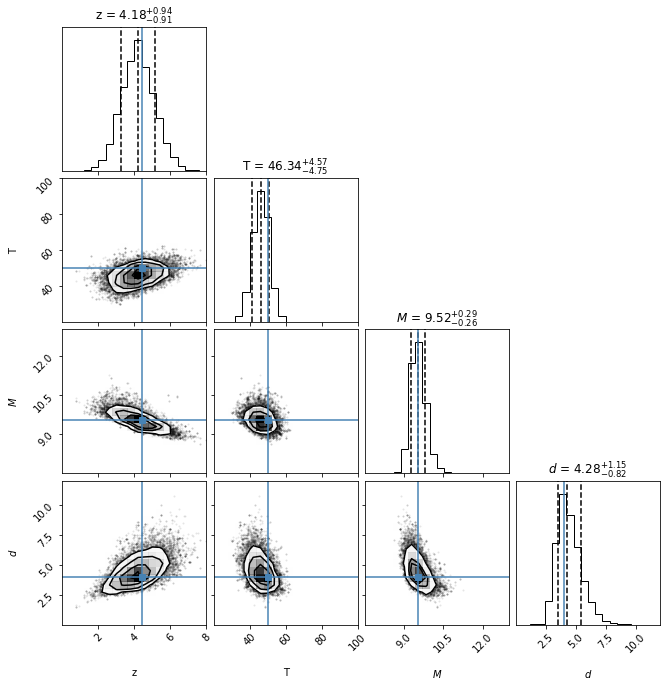

In [37]:
mcmc_PL_lim(ID[4],frecs4T,errf4T,"PL lim") 

ACT-S J0045_0001

In [38]:
frecs5T=[v1[5],v2[5],v3[5],l1[5],l2[5],l3[5]]
errf5T=[ev1[5],ev2[5],ev3[5],el1[5],el2[5],el3[5]]

Multiprocessing took 130.1 minutes
2:10:08.622351


<Figure size 864x648 with 0 Axes>

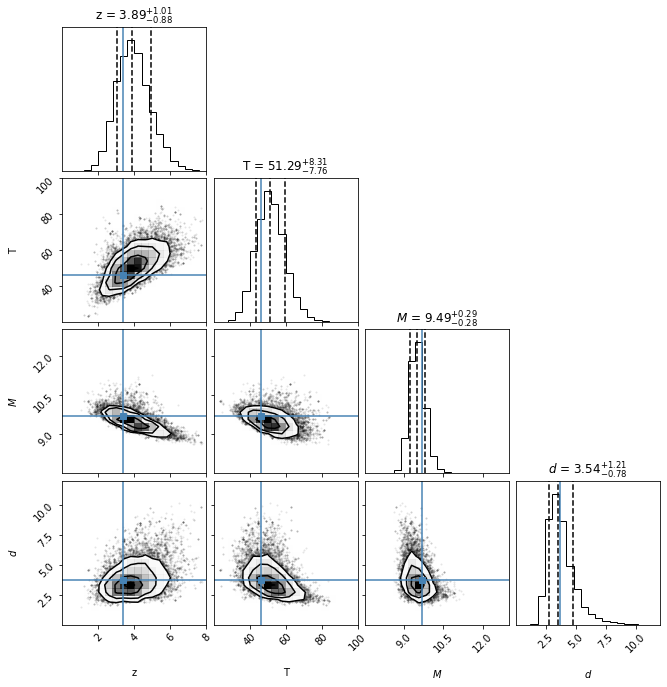

In [39]:
mcmc_S(ID[5],frecs5T,errf5T,"S") 

In [40]:
mcmc_PL_lim(ID[5],frecs5T,errf5T,"PL lim") 

Process ForkPoolWorker-43:
Process ForkPoolWorker-42:
Process ForkPoolWorker-44:
Process ForkPoolWorker-41:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, i

emcee: Exception while calling your likelihood function:
  params: [ 5.87484189 50.2386973   9.19058944  3.4553081 ]
  args: (array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([ 6.46, 24.99, 45.87, 97.18, 87.61, 48.22]), array([1.9 , 2.51, 6.23, 7.36, 6.28, 6.73]), 'PL lim')
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-15-def83b638be5>", line 5, in lnprob
    return lp + lnlike(theta, x, y, yerr,model)
  File "<ipython-input-13-c717fabbd2d9>", line 6, in lnlike
    Sobs = modelSobs(x,z,T,M_,d_)
  File "<ipython-input-9-8f94b12425d0>", line 8, in modelSobs
    INTEGRAL=A(z,Tc,M_,d_,vf)
  File "<ipython-input-8-391b73b12bf0>", line 13, in A
    ARG = modelSv(i,z,Tvariable,M_,d_)*un.mJy *(Tvariable)**-7
  File "<ipython-input-7-92826b2579fe>", line 9, in modelSv
    PL=P(vf,T,z)
  File "<ipython-input-6-12c7ed8bdbd0>", line 3, in P
    T=T*un.K
  File "/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py", line 943, in __mul__
    return self._new_view(self.copy(), other * self.unit)
  File "/opt/anaconda3/lib/python3.7/site-packages/astropy/units/core.py", line 692, in __mul__
    return Com

KeyboardInterrupt: 

<Figure size 864x648 with 0 Axes>

ACT-S J0107+0001

In [ ]:
frecs6T=[v1[6],v2[6],v3[6],l1[6],l2[6],l3[6]]
errf6T=[ev1[6],ev2[6],ev3[6],el1[6],el2[6],el3[6]]

In [ ]:
mcmc_S(ID[6],frecs6T,errf6T,"S") 

In [ ]:
mcmc_PL_lim(ID[6],frecs6T,errf6T,"PL lim") 

ACT-S J0116_0004

In [ ]:
frecs7T=[v1[7],v2[7],v3[7],l1[7],l2[7],l3[7]]
errf7T=[ev1[7],ev2[7],ev3[7],el1[7],el2[7],el3[7]]

In [ ]:
mcmc_S(ID[7],frecs7T,errf7T,"S") 

In [ ]:
mcmc_PL_lim(ID[7],frecs7T,errf7T,"PL lim") 

ACT-S J0210+0016

In [ ]:
frecs8T=[v1[8],v2[8],v3[8],l1[8],l2[8],l3[8]]
errf8T=[ev1[8],ev2[8],ev3[8],el1[8],el2[8],el3[8]]

In [ ]:
mcmc_S(ID[8],frecs8T,errf8T,"S") 

In [ ]:
mcmc_PL_lim(ID[8],frecs8T,errf8T,"PL lim") 